In [1]:
'------------------------------------------------- Initial Setup -------------------------------------------------'

%matplotlib inline
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import interp
from pprint import pprint
from itertools import cycle
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.externals import joblib
from TrainTestSplit import trainTestSplit
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


np.set_printoptions(precision = 2)

In [2]:
## Loading in the data of Set A.
XTrain, XTest, YTrain, YTest = trainTestSplit("A")

In [3]:
## Setting the classifier to be Vanilla RandomForestClassifier.
Classifier = RandomForestClassifier(oob_score = True)

## Defining a list to store the Cross-Validation Scores.
crossValidationScores = []

## Computing the 10-fold cross-validation score.
cvScore = cross_val_score(Classifier, XTrain, YTrain['FTR'], cv = 10)
crossValidationScores.append(np.mean(cvScore))
print "Cross Validation Score : ", np.mean(crossValidationScores)

## Computing the Training and Testing Accuracies.
Classifier.fit(XTrain,YTrain)
print "Training Accuracy : ", Classifier.score(XTrain, YTrain)
print "Testing Accuracy : ", Classifier.score(XTest, YTest)

Cross Validation Score :  0.475295072845
Training Accuracy :  0.986328681287
Testing Accuracy :  0.4796875


In [4]:
## Defining the hyperparameter space for searching the optimum set of hyperparameter values .
parameters = { 'n_estimators' : [150, 200, 250, 300],
               'criterion' : ['gini', 'entropy'],
               'max_features' : ['sqrt', 'log2'],
               'max_depth' : [5, 8, 10, None],
               'min_samples_split' : [2, 5, 10, 15, 100],
               'min_samples_leaf' : [1, 2, 5, 10]
              }

In [5]:
## Loading the already tuned model with the above set of hyperparameters.
Clf = joblib.load('./GridSearchObjects/RFSetA.pkl')

In [6]:
## Uncomment this block if you want to run the grid search yourself.
## Note : This is going to be computationally very expensive on your CPU !

# Clf = GridSearchCV(Classifier, parameters, n_jobs = 5, verbose = 4, scoring = 'accuracy')

# ## Fitting the Model to the Training Data.
# Clf.fit(XTrain, YTrain.values.ravel())

In [7]:
## Printing the statistics after hyper-parameter tuning.
print Clf.best_score_
print Clf.best_estimator_

0.538592993449
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=2,
            min_samples_split=100, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)


In [8]:
## Setting the classifier to be the hyperparameter tuned Random Forest Classifier.
## Classifier = Clf.best_estimator_

## Defining a list to store the Cross-Validation Scores.
crossValidationScores = []

## Computing the 10-fold cross-validation score.
cvScore = cross_val_score(Classifier, XTrain, YTrain['FTR'], cv = 10)
crossValidationScores.append(np.mean(cvScore))
print "Cross Validation Score : ", np.mean(crossValidationScores)

## Computing the Training and Testing Accuracies.
Classifier.fit(XTrain,YTrain)
print "Training Accuracy : ", Classifier.score(XTrain, YTrain)
print "Testing Accuracy : ", Classifier.score(XTest, YTest)

Cross Validation Score :  0.45881445679
Training Accuracy :  0.987183138707
Testing Accuracy :  0.4859375


In [9]:
## Obtaining our predictions made by the best Gaussian Naive Bayes Classifier .
YPred = Classifier.predict(XTest)

## Defining the target classes .
classLabels = ['H','A','D']

## Obtaining the confusion matrix for our predictions .
confusionMatrix = confusion_matrix(YTest['FTR'], YPred, classLabels)
confusionMatrix

array([[199,  60,  49],
       [ 72,  76,  26],
       [ 88,  34,  36]])

In [10]:
## Obtaining a more readable format of our Confusion Matrix in terms of a Classification Report . 

classificationReport = classification_report(YTest, YPred, classLabels)
print classificationReport

             precision    recall  f1-score   support

          H       0.55      0.65      0.60       308
          A       0.45      0.44      0.44       174
          D       0.32      0.23      0.27       158

avg / total       0.47      0.49      0.47       640



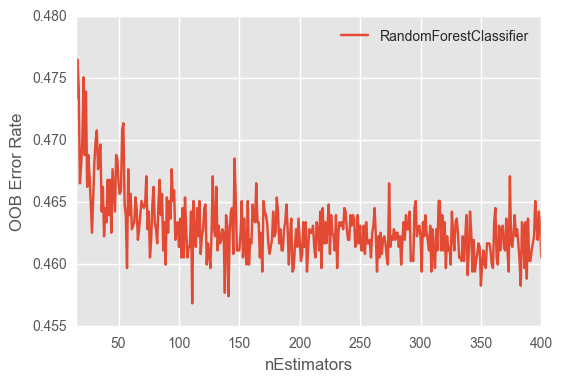

In [11]:
plt.style.use('ggplot')

ensembleClfs = [("RandomForestClassifier", 
                RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                max_depth=8, max_features='sqrt', max_leaf_nodes=None,
                min_impurity_split=1e-07, min_samples_leaf=1,
                min_samples_split=100, min_weight_fraction_leaf=0.0,
                n_estimators=150, n_jobs=1, oob_score=True, random_state=None,
                verbose=0, warm_start = False))]


## Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
errorRate = OrderedDict((label, []) for label, _ in ensembleClfs)

# Range of nEstimators values to explore.
minEstimators = 15
maxEstimators = 400

for label, clf in ensembleClfs:
    for i in range(minEstimators, maxEstimators + 1):
        
        clf.set_params(n_estimators = i)
        clf.fit(XTrain, YTrain)

        ## Record the OOB error for each n_estimators = i setting.
        oobError = 1 - clf.oob_score_
        errorRate[label].append((i, oobError))

## Generate the "OOB error rate" vs. "nEstimators" plot.
for label, clfErr in errorRate.items():
    xs, ys = zip(*clfErr)
    plt.plot(xs, ys, label = label)

plt.xlim(minEstimators, maxEstimators)
plt.xlabel("nEstimators")
plt.ylabel("OOB Error Rate")
plt.legend(loc = "upper right")
plt.show()

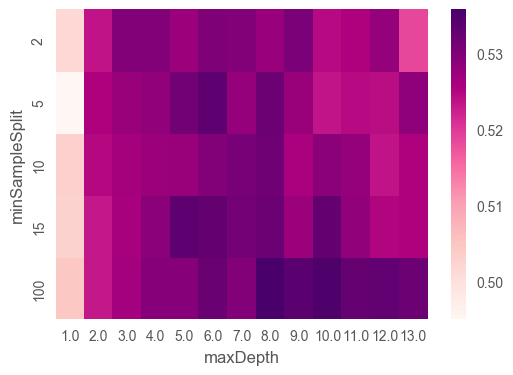

In [12]:
gridScores = Clf.grid_scores_

gridScoresList = []

for i in range(0, len(gridScores)):

    Score = (gridScores[i][1],)
    maxDepth = (gridScores[i][0]['max_depth'],)
    minSampleSplit = (gridScores[i][0]['min_samples_split'],)

    Tuple = Score + maxDepth + minSampleSplit
    gridScoresList.append(Tuple)
    
df = pd.DataFrame(gridScoresList, columns = ['Validation Score', 'maxDepth', 'minSampleSplit'])
df = df.drop_duplicates(subset = ['maxDepth', 'minSampleSplit'])
df = df[np.isfinite(df['maxDepth'])]

gridMap = df.pivot("minSampleSplit", "maxDepth", "Validation Score")
sns.heatmap(gridMap, cmap = "RdPu")

In [13]:
## Loading in the data of Set A.
XTrain, XTest, YTrain, YTest = trainTestSplit("A")

## Visualising a comparison between the true and predicted class results.
## Defining the Final Result labels .
resultsLabels = ['Away','Draw','Home']

## Defining the True Labels .
trueValues = list(list(np.unique(YTest['FTR'] , return_counts = True))[1])

## Computing Predictions with our fine-tuned Naive Bayes Classifier .
YPred = Classifier.predict(XTest)
predValues = list(list(np.unique(YPred , return_counts = True))[1])

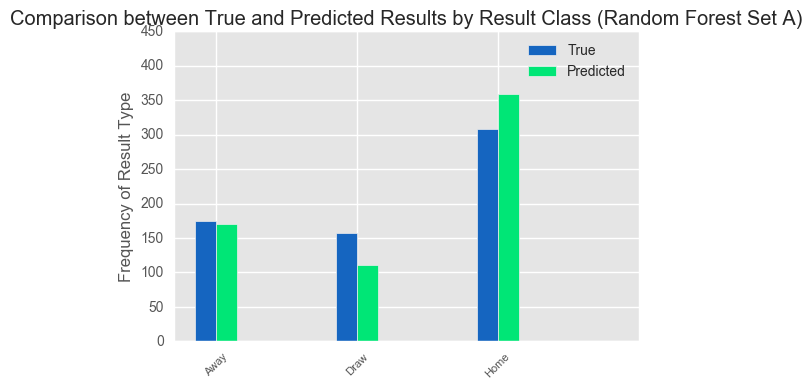

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
ind = np.arange(3)
width = 0.15      
rects1 = ax.bar(ind, trueValues, width, color = '#1565C0', error_kw = dict(elinewidth = 2, ecolor = 'blue'))

rects2 = ax.bar(ind + width, predValues, width, color = '#00E676', error_kw = dict(elinewidth = 2, ecolor = 'black'))

ax.set_xlim(-width,len(ind) + width)
ax.set_ylim(0, 450)
ax.set_ylabel('Frequency of Result Type')
ax.set_title('Comparison between True and Predicted Results by Result Class (Random Forest Set A)')
xTickMarks = resultsLabels
ax.set_xticks(ind + width)
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation = 45, fontsize = 8)
ax.legend( (rects1[0], rects2[0]), ('True', 'Predicted') )
plt.show()